In [17]:
import os


def create_data_list(root_dir, data_name, save_paths):
  data_path = os.path.join(root_dir, data_name)
  labels = os.listdir(data_path)
  imgs_paths = []
  class_labels = []
  for label in labels:
    img_names = os.listdir(os.path.join(data_path, label))
    class_labels.extend([label] * len(img_names))
    for img_name in img_names:
      img_full_path = os.path.join(data_path, label, img_name)
      imgs_paths.append(img_full_path)

  if os.path.exists(save_paths[0]) and os.path.exists(save_paths[1]):
    with open(save_paths[0], "w") as fd:
      fd.write("\n".join(imgs_paths))
    
    with open(save_paths[1], "w") as fd:
      fd.write("\n".join(class_labels))

create_data_list("./oxford-flowers17", "train", ("train_files.txt", "train_labels.txt"))
create_data_list("./oxford-flowers17", "val", ("val_files.txt", "val_labels.txt"))
create_data_list("./oxford-flowers17", "test", ("test_files.txt", "test_labels.txt"))

In [2]:
!nvidia-smi

Fri Apr 28 21:27:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install torchsummaryX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import os
import gc
from tqdm import tqdm
import numpy as np
import scipy
from torchsummaryX import summary
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import transforms

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


In [24]:
class FlowerDataset(torch.utils.data.Dataset):
    def __init__(self, mode="train"):
      self.xs = np.loadtxt(f"{mode}_files.txt", delimiter="\n", dtype="str")
      self.ys = np.loadtxt(f"{mode}_labels.txt", delimiter="\n")
      self.img_transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
      ])

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
      with Image.open(self.xs[idx]) as img:
        img = self.img_transform(img)
        if img.shape[0] == 1:
          img = img.repeat(3, 1, 1)
        label = self.ys[idx]
        return img, label

In [25]:
max_iters = 50
batch_size = 128
learning_rate = 1e-3

In [26]:
train_dataset = FlowerDataset(mode="train")
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    drop_last=False,
)

val_dataset = FlowerDataset(mode="val")
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=False,
)

test_dataset = FlowerDataset(mode="test")
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=False,
)

In [69]:
class LeNet(torch.nn.Module):
    def __init__(self, in_channels=3, out_size=17):
        super(LeNet, self).__init__()
        layers = [
          torch.nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Flatten(),
          torch.nn.Linear(16*53*53, 120),
          torch.nn.ReLU(),
          torch.nn.Linear(120, 84),
          torch.nn.ReLU(),
          torch.nn.Linear(84, out_size)
        ]
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [70]:
convnet = LeNet().to(device)
imgs, labels = next(iter(train_loader))
summary(convnet, imgs.to(device))

                        Kernel Shape         Output Shape   Params  Mult-Adds
Layer                                                                        
0_network.Conv2d_0      [3, 6, 5, 5]   [128, 6, 223, 223]    456.0  22.37805M
1_network.ReLU_1                   -   [128, 6, 223, 223]        -          -
2_network.MaxPool2d_2              -   [128, 6, 111, 111]        -          -
3_network.Conv2d_3     [6, 16, 5, 5]  [128, 16, 107, 107]   2.416k   27.4776M
4_network.ReLU_4                   -  [128, 16, 107, 107]        -          -
5_network.MaxPool2d_5              -    [128, 16, 53, 53]        -          -
6_network.Flatten_6                -         [128, 44944]        -          -
7_network.Linear_7      [44944, 120]           [128, 120]  5.3934M   5.39328M
8_network.ReLU_8                   -           [128, 120]        -          -
9_network.Linear_9         [120, 84]            [128, 84]  10.164k     10.08k
10_network.ReLU_10                 -            [128, 84]       

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_network.Conv2d_0,"[3, 6, 5, 5]","[128, 6, 223, 223]",456.0,22378050.0
1_network.ReLU_1,-,"[128, 6, 223, 223]",NaN,NaN
2_network.MaxPool2d_2,-,"[128, 6, 111, 111]",NaN,NaN
3_network.Conv2d_3,"[6, 16, 5, 5]","[128, 16, 107, 107]",2416.0,27477600.0
4_network.ReLU_4,-,"[128, 16, 107, 107]",NaN,NaN
5_network.MaxPool2d_5,-,"[128, 16, 53, 53]",NaN,NaN
6_network.Flatten_6,-,"[128, 44944]",NaN,NaN
7_network.Linear_7,"[44944, 120]","[128, 120]",5393400.0,5393280.0
8_network.ReLU_8,-,"[128, 120]",NaN,NaN


In [71]:
def train(model, optimizer, criterion, dataloader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total_instances = 0
    for iter, (xb, yb) in enumerate(dataloader):
      xb = xb.to(device)
      yb = yb.type(torch.LongTensor)
      yb = yb.to(device)
      
      logits = model(xb)
      loss = criterion(logits, yb)
      
      train_loss += loss.item()
      train_acc += (torch.argmax(logits, dim=1) == yb).sum().item()
      
      optimizer.zero_grad()
      
      loss.backward()
      optimizer.step()

      total_instances += len(xb)

    train_loss /= len(dataloader)
    train_acc /= total_instances
    return train_loss, train_acc


def eval(model, dataloader):
    model.eval()
    val_acc = 0.0
    total_instances = 0
    with torch.inference_mode():
      for iter, (xb, yb) in enumerate(dataloader):
        xb = xb.to(device)
        yb = yb.type(torch.LongTensor)
        yb = yb.to(device)
        
        logits = model(xb)
        val_acc += (torch.argmax(logits, dim=1) == yb).sum().item()
        total_instances += len(xb)

    val_acc /= total_instances
    return val_acc

In [72]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(convnet.parameters(), lr=learning_rate, weight_decay=0.01,)

In [73]:
gc.collect()

404

In [74]:
torch.cuda.empty_cache()
best_acc = 0.0

train_losses = []
train_accs = []
val_accs = []

checkpoint_path = "./flower17_convnet_model_checkpoint.pth"

for epoch in tqdm(range(max_iters)):
    train_loss, train_accuracy = train(convnet, optimizer, criterion, train_loader)
    val_accuracy = eval(convnet, val_loader)

    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

    print("Epoch {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f} | Val Accuracy: {:.2f}".format(epoch+1, max_iters, train_loss, train_accuracy, val_accuracy))
    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save({
          "epoch": epoch,
          "model_state_dict": convnet.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "loss": train_loss,
          "val_accuracy": val_accuracy}, checkpoint_path)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 2.7224 | Train Accuracy: 0.10 | Val Accuracy: 0.17


  4%|▍         | 2/50 [00:16<06:42,  8.38s/it]

Epoch 2/50 | Train Loss: 2.3017 | Train Accuracy: 0.21 | Val Accuracy: 0.24


  6%|▌         | 3/50 [00:25<06:43,  8.59s/it]

Epoch 3/50 | Train Loss: 2.0307 | Train Accuracy: 0.30 | Val Accuracy: 0.24


  8%|▊         | 4/50 [00:33<06:22,  8.30s/it]

Epoch 4/50 | Train Loss: 1.7227 | Train Accuracy: 0.43 | Val Accuracy: 0.37


 10%|█         | 5/50 [00:41<06:19,  8.44s/it]

Epoch 5/50 | Train Loss: 1.5219 | Train Accuracy: 0.52 | Val Accuracy: 0.33


 12%|█▏        | 6/50 [00:50<06:16,  8.55s/it]

Epoch 6/50 | Train Loss: 1.4543 | Train Accuracy: 0.50 | Val Accuracy: 0.38


 14%|█▍        | 7/50 [00:58<05:57,  8.32s/it]

Epoch 7/50 | Train Loss: 1.2524 | Train Accuracy: 0.59 | Val Accuracy: 0.44


 16%|█▌        | 8/50 [01:07<05:55,  8.47s/it]

Epoch 8/50 | Train Loss: 1.0845 | Train Accuracy: 0.63 | Val Accuracy: 0.42


 18%|█▊        | 9/50 [01:16<05:49,  8.52s/it]

Epoch 9/50 | Train Loss: 0.9424 | Train Accuracy: 0.70 | Val Accuracy: 0.48


 20%|██        | 10/50 [01:23<05:31,  8.28s/it]

Epoch 10/50 | Train Loss: 0.7811 | Train Accuracy: 0.75 | Val Accuracy: 0.45


 22%|██▏       | 11/50 [01:32<05:27,  8.40s/it]

Epoch 11/50 | Train Loss: 0.6961 | Train Accuracy: 0.79 | Val Accuracy: 0.51


 24%|██▍       | 12/50 [01:41<05:20,  8.45s/it]

Epoch 12/50 | Train Loss: 0.6195 | Train Accuracy: 0.81 | Val Accuracy: 0.49


 26%|██▌       | 13/50 [01:48<05:03,  8.21s/it]

Epoch 13/50 | Train Loss: 0.4471 | Train Accuracy: 0.86 | Val Accuracy: 0.46


 28%|██▊       | 14/50 [01:57<04:59,  8.32s/it]

Epoch 14/50 | Train Loss: 0.3369 | Train Accuracy: 0.93 | Val Accuracy: 0.48


 30%|███       | 15/50 [02:05<04:53,  8.39s/it]

Epoch 15/50 | Train Loss: 0.2546 | Train Accuracy: 0.95 | Val Accuracy: 0.49


 32%|███▏      | 16/50 [02:13<04:37,  8.17s/it]

Epoch 16/50 | Train Loss: 0.2593 | Train Accuracy: 0.93 | Val Accuracy: 0.48


 34%|███▍      | 17/50 [02:22<04:33,  8.29s/it]

Epoch 17/50 | Train Loss: 0.2545 | Train Accuracy: 0.91 | Val Accuracy: 0.46


 36%|███▌      | 18/50 [02:30<04:27,  8.36s/it]

Epoch 18/50 | Train Loss: 0.2178 | Train Accuracy: 0.94 | Val Accuracy: 0.49


 38%|███▊      | 19/50 [02:38<04:13,  8.18s/it]

Epoch 19/50 | Train Loss: 0.1487 | Train Accuracy: 0.96 | Val Accuracy: 0.50


 40%|████      | 20/50 [02:46<04:09,  8.32s/it]

Epoch 20/50 | Train Loss: 0.1317 | Train Accuracy: 0.97 | Val Accuracy: 0.51


 42%|████▏     | 21/50 [02:55<04:04,  8.42s/it]

Epoch 21/50 | Train Loss: 0.1040 | Train Accuracy: 0.98 | Val Accuracy: 0.51


 44%|████▍     | 22/50 [03:03<03:51,  8.27s/it]

Epoch 22/50 | Train Loss: 0.0547 | Train Accuracy: 0.99 | Val Accuracy: 0.50


 46%|████▌     | 23/50 [03:11<03:44,  8.32s/it]

Epoch 23/50 | Train Loss: 0.0409 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 48%|████▊     | 24/50 [03:20<03:38,  8.40s/it]

Epoch 24/50 | Train Loss: 0.0326 | Train Accuracy: 1.00 | Val Accuracy: 0.50


 50%|█████     | 25/50 [03:28<03:28,  8.35s/it]

Epoch 25/50 | Train Loss: 0.0334 | Train Accuracy: 0.99 | Val Accuracy: 0.50


 52%|█████▏    | 26/50 [03:37<03:19,  8.32s/it]

Epoch 26/50 | Train Loss: 0.0252 | Train Accuracy: 1.00 | Val Accuracy: 0.49


 54%|█████▍    | 27/50 [03:45<03:12,  8.37s/it]

Epoch 27/50 | Train Loss: 0.0207 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 56%|█████▌    | 28/50 [03:53<03:02,  8.29s/it]

Epoch 28/50 | Train Loss: 0.0205 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 58%|█████▊    | 29/50 [04:01<02:52,  8.23s/it]

Epoch 29/50 | Train Loss: 0.0156 | Train Accuracy: 1.00 | Val Accuracy: 0.48


 60%|██████    | 30/50 [04:10<02:46,  8.32s/it]

Epoch 30/50 | Train Loss: 0.0146 | Train Accuracy: 1.00 | Val Accuracy: 0.51
Epoch 31/50 | Train Loss: 0.0095 | Train Accuracy: 1.00 | Val Accuracy: 0.52


 64%|██████▍   | 32/50 [04:26<02:28,  8.23s/it]

Epoch 32/50 | Train Loss: 0.0083 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 66%|██████▌   | 33/50 [04:35<02:22,  8.37s/it]

Epoch 33/50 | Train Loss: 0.0077 | Train Accuracy: 1.00 | Val Accuracy: 0.54


 68%|██████▊   | 34/50 [04:43<02:15,  8.44s/it]

Epoch 34/50 | Train Loss: 0.0049 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 70%|███████   | 35/50 [04:51<02:03,  8.21s/it]

Epoch 35/50 | Train Loss: 0.0036 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 72%|███████▏  | 36/50 [05:00<01:56,  8.35s/it]

Epoch 36/50 | Train Loss: 0.0028 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 74%|███████▍  | 37/50 [05:08<01:49,  8.39s/it]

Epoch 37/50 | Train Loss: 0.0023 | Train Accuracy: 1.00 | Val Accuracy: 0.52


 76%|███████▌  | 38/50 [05:16<01:38,  8.18s/it]

Epoch 38/50 | Train Loss: 0.0017 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 78%|███████▊  | 39/50 [05:25<01:31,  8.35s/it]

Epoch 39/50 | Train Loss: 0.0016 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 80%|████████  | 40/50 [05:33<01:24,  8.41s/it]

Epoch 40/50 | Train Loss: 0.0014 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 82%|████████▏ | 41/50 [05:41<01:13,  8.19s/it]

Epoch 41/50 | Train Loss: 0.0013 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 84%|████████▍ | 42/50 [05:49<01:06,  8.29s/it]

Epoch 42/50 | Train Loss: 0.0012 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 86%|████████▌ | 43/50 [05:58<00:58,  8.37s/it]

Epoch 43/50 | Train Loss: 0.0011 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 88%|████████▊ | 44/50 [06:06<00:48,  8.16s/it]

Epoch 44/50 | Train Loss: 0.0011 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 90%|█████████ | 45/50 [06:14<00:41,  8.29s/it]

Epoch 45/50 | Train Loss: 0.0010 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 92%|█████████▏| 46/50 [06:23<00:33,  8.40s/it]

Epoch 46/50 | Train Loss: 0.0010 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 94%|█████████▍| 47/50 [06:31<00:24,  8.18s/it]

Epoch 47/50 | Train Loss: 0.0010 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 96%|█████████▌| 48/50 [06:39<00:16,  8.29s/it]

Epoch 48/50 | Train Loss: 0.0009 | Train Accuracy: 1.00 | Val Accuracy: 0.51


 98%|█████████▊| 49/50 [06:48<00:08,  8.38s/it]

Epoch 49/50 | Train Loss: 0.0009 | Train Accuracy: 1.00 | Val Accuracy: 0.51


100%|██████████| 50/50 [06:55<00:00,  8.32s/it]

Epoch 50/50 | Train Loss: 0.0008 | Train Accuracy: 1.00 | Val Accuracy: 0.51


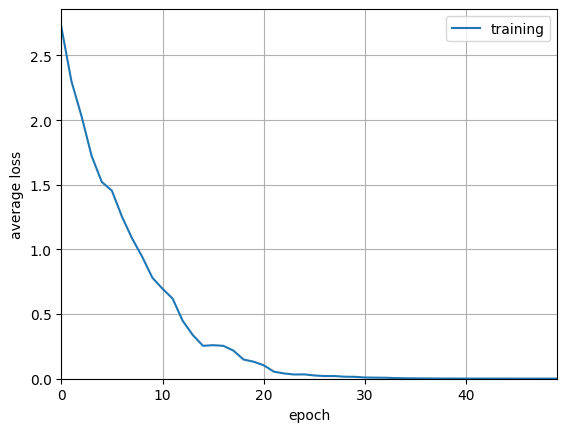

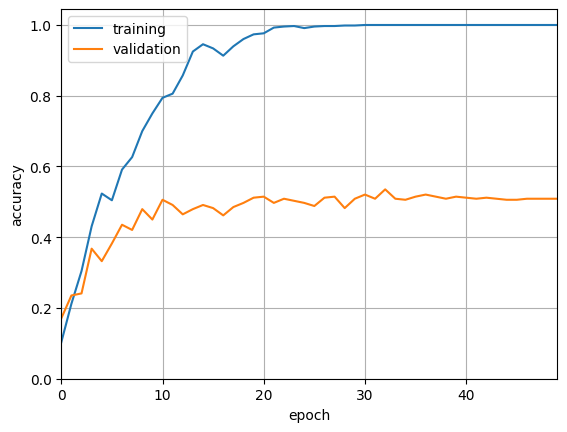

In [75]:
# plot loss curves
plt.plot(range(len(train_losses)), train_losses, label="training")
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.xlim(0, len(train_losses) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

# plot accuracy curves
plt.plot(range(len(train_accs)), train_accs, label="training")
plt.plot(range(len(val_accs)), val_accs, label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(0, len(train_accs) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

In [96]:
model = LeNet().to(device)
model_state_dict_path = torch.load("./flower17_convnet_model_checkpoint.pth")
model.load_state_dict(model_state_dict_path["model_state_dict"])

<All keys matched successfully>

In [97]:
test_accuracy = eval(model, test_loader)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.4970588235294118


In [90]:
class SqueezeNet(torch.nn.Module):
  def __init__(self, in_channels=3, out_size=17):
    super(SqueezeNet, self).__init__()
    self.backbone = torchvision.models.squeezenet1_1(weights="SqueezeNet1_1_Weights.IMAGENET1K_V1").features
    self.classifier = torch.nn.Sequential(
        torch.nn.Dropout(0.1),
        torch.nn.Conv2d(512, out_size, kernel_size=1),
        torch.nn.ReLU(),
        torch.nn.AdaptiveAvgPool2d((1, 1))
    )

  def forward(self, x):
    embedding = self.backbone(x)
    out = self.classifier(embedding)
    out = torch.flatten(out, 1)
    return out


In [91]:
snet = SqueezeNet().to(device)
imgs, labels = next(iter(train_loader))
summary(snet, imgs.to(device))

                                             Kernel Shape  \
Layer                                                       
0_backbone.Conv2d_0                         [3, 64, 3, 3]   
1_backbone.ReLU_1                                       -   
2_backbone.MaxPool2d_2                                  -   
3_backbone.3.Conv2d_squeeze                [64, 16, 1, 1]   
4_backbone.3.ReLU_squeeze_activation                    -   
5_backbone.3.Conv2d_expand1x1              [16, 64, 1, 1]   
6_backbone.3.ReLU_expand1x1_activation                  -   
7_backbone.3.Conv2d_expand3x3              [16, 64, 3, 3]   
8_backbone.3.ReLU_expand3x3_activation                  -   
9_backbone.4.Conv2d_squeeze               [128, 16, 1, 1]   
10_backbone.4.ReLU_squeeze_activation                   -   
11_backbone.4.Conv2d_expand1x1             [16, 64, 1, 1]   
12_backbone.4.ReLU_expand1x1_activation                 -   
13_backbone.4.Conv2d_expand3x3             [16, 64, 3, 3]   
14_backbone.4.ReLU_expan

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_backbone.Conv2d_0,"[3, 64, 3, 3]","[128, 64, 113, 113]",1792.0,22064832.0
1_backbone.ReLU_1,-,"[128, 64, 113, 113]",NaN,NaN
2_backbone.MaxPool2d_2,-,"[128, 64, 56, 56]",NaN,NaN
3_backbone.3.Conv2d_squeeze,"[64, 16, 1, 1]","[128, 16, 56, 56]",1040.0,3211264.0
4_backbone.3.ReLU_squeeze_activation,-,"[128, 16, 56, 56]",NaN,NaN
5_backbone.3.Conv2d_expand1x1,"[16, 64, 1, 1]","[128, 64, 56, 56]",1088.0,3211264.0
6_backbone.3.ReLU_expand1x1_activation,-,"[128, 64, 56, 56]",NaN,NaN
7_backbone.3.Conv2d_expand3x3,"[16, 64, 3, 3]","[128, 64, 56, 56]",9280.0,28901376.0
8_backbone.3.ReLU_expand3x3_activation,-,"[128, 64, 56, 56]",NaN,NaN


In [92]:
for param in snet.parameters():
  param.requires_grad = False

for param in snet.classifier.parameters():
  param.requires_grad = True

In [93]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(snet.parameters(), lr=learning_rate, weight_decay=0.01,)

In [94]:
torch.cuda.empty_cache()
best_acc = 0.0

train_losses = []
train_accs = []
val_accs = []

checkpoint_path = "./flower17_snet_model_checkpoint.pth"

for epoch in tqdm(range(max_iters)):
    train_loss, train_accuracy = train(snet, optimizer, criterion, train_loader)
    val_accuracy = eval(snet, val_loader)

    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

    print("Epoch {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f} | Val Accuracy: {:.2f}".format(epoch+1, max_iters, train_loss, train_accuracy, val_accuracy))
    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save({
          "epoch": epoch,
          "model_state_dict": snet.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "loss": train_loss,
          "val_accuracy": val_accuracy}, checkpoint_path)


  2%|▏         | 1/50 [00:08<06:37,  8.12s/it]

Epoch 1/50 | Train Loss: 2.9377 | Train Accuracy: 0.10 | Val Accuracy: 0.23


  4%|▍         | 2/50 [00:17<06:52,  8.59s/it]

Epoch 2/50 | Train Loss: 2.2542 | Train Accuracy: 0.35 | Val Accuracy: 0.42


  6%|▌         | 3/50 [00:25<06:51,  8.76s/it]

Epoch 3/50 | Train Loss: 1.8169 | Train Accuracy: 0.57 | Val Accuracy: 0.54


  8%|▊         | 4/50 [00:34<06:30,  8.49s/it]

Epoch 4/50 | Train Loss: 1.4692 | Train Accuracy: 0.65 | Val Accuracy: 0.62


 10%|█         | 5/50 [00:43<06:29,  8.65s/it]

Epoch 5/50 | Train Loss: 1.2183 | Train Accuracy: 0.73 | Val Accuracy: 0.64


 12%|█▏        | 6/50 [00:51<06:25,  8.76s/it]

Epoch 6/50 | Train Loss: 0.9647 | Train Accuracy: 0.77 | Val Accuracy: 0.71


 14%|█▍        | 7/50 [01:00<06:15,  8.72s/it]

Epoch 7/50 | Train Loss: 0.7985 | Train Accuracy: 0.84 | Val Accuracy: 0.73


 16%|█▌        | 8/50 [01:09<06:02,  8.63s/it]

Epoch 8/50 | Train Loss: 0.6616 | Train Accuracy: 0.87 | Val Accuracy: 0.77


 18%|█▊        | 9/50 [01:18<05:59,  8.77s/it]

Epoch 9/50 | Train Loss: 0.5655 | Train Accuracy: 0.88 | Val Accuracy: 0.78


 20%|██        | 10/50 [01:27<05:53,  8.84s/it]

Epoch 10/50 | Train Loss: 0.4880 | Train Accuracy: 0.90 | Val Accuracy: 0.79


 22%|██▏       | 11/50 [01:35<05:35,  8.60s/it]

Epoch 11/50 | Train Loss: 0.4471 | Train Accuracy: 0.92 | Val Accuracy: 0.80


 24%|██▍       | 12/50 [01:44<05:30,  8.70s/it]

Epoch 12/50 | Train Loss: 0.4171 | Train Accuracy: 0.93 | Val Accuracy: 0.81


 26%|██▌       | 13/50 [01:53<05:26,  8.82s/it]

Epoch 13/50 | Train Loss: 0.3851 | Train Accuracy: 0.94 | Val Accuracy: 0.81


 28%|██▊       | 14/50 [02:01<05:11,  8.65s/it]

Epoch 14/50 | Train Loss: 0.3444 | Train Accuracy: 0.95 | Val Accuracy: 0.82


 30%|███       | 15/50 [02:10<05:03,  8.68s/it]

Epoch 15/50 | Train Loss: 0.3055 | Train Accuracy: 0.95 | Val Accuracy: 0.82


 32%|███▏      | 16/50 [02:19<04:58,  8.79s/it]

Epoch 16/50 | Train Loss: 0.2802 | Train Accuracy: 0.95 | Val Accuracy: 0.84


 34%|███▍      | 17/50 [02:28<04:51,  8.84s/it]

Epoch 17/50 | Train Loss: 0.2677 | Train Accuracy: 0.96 | Val Accuracy: 0.82


 36%|███▌      | 18/50 [02:36<04:36,  8.63s/it]

Epoch 18/50 | Train Loss: 0.2513 | Train Accuracy: 0.96 | Val Accuracy: 0.83


 38%|███▊      | 19/50 [02:45<04:30,  8.74s/it]

Epoch 19/50 | Train Loss: 0.2383 | Train Accuracy: 0.97 | Val Accuracy: 0.84


 40%|████      | 20/50 [02:54<04:25,  8.85s/it]

Epoch 20/50 | Train Loss: 0.2175 | Train Accuracy: 0.97 | Val Accuracy: 0.83


 42%|████▏     | 21/50 [03:02<04:09,  8.61s/it]

Epoch 21/50 | Train Loss: 0.2034 | Train Accuracy: 0.97 | Val Accuracy: 0.83


 44%|████▍     | 22/50 [03:11<04:04,  8.72s/it]

Epoch 22/50 | Train Loss: 0.1857 | Train Accuracy: 0.98 | Val Accuracy: 0.84


 46%|████▌     | 23/50 [03:20<03:57,  8.81s/it]

Epoch 23/50 | Train Loss: 0.1824 | Train Accuracy: 0.98 | Val Accuracy: 0.82


 48%|████▊     | 24/50 [03:29<03:48,  8.80s/it]

Epoch 24/50 | Train Loss: 0.1744 | Train Accuracy: 0.98 | Val Accuracy: 0.83


 50%|█████     | 25/50 [03:37<03:35,  8.63s/it]

Epoch 25/50 | Train Loss: 0.1632 | Train Accuracy: 0.99 | Val Accuracy: 0.84


 52%|█████▏    | 26/50 [03:46<03:29,  8.75s/it]

Epoch 26/50 | Train Loss: 0.1579 | Train Accuracy: 0.99 | Val Accuracy: 0.84


 54%|█████▍    | 27/50 [03:55<03:22,  8.83s/it]

Epoch 27/50 | Train Loss: 0.1517 | Train Accuracy: 0.99 | Val Accuracy: 0.84


 56%|█████▌    | 28/50 [04:03<03:09,  8.63s/it]

Epoch 28/50 | Train Loss: 0.1340 | Train Accuracy: 0.99 | Val Accuracy: 0.84


 58%|█████▊    | 29/50 [04:12<03:02,  8.71s/it]

Epoch 29/50 | Train Loss: 0.1334 | Train Accuracy: 0.99 | Val Accuracy: 0.83


 60%|██████    | 30/50 [04:21<02:55,  8.78s/it]

Epoch 30/50 | Train Loss: 0.1415 | Train Accuracy: 0.99 | Val Accuracy: 0.84


 62%|██████▏   | 31/50 [04:29<02:44,  8.66s/it]

Epoch 31/50 | Train Loss: 0.1216 | Train Accuracy: 0.99 | Val Accuracy: 0.86


 64%|██████▍   | 32/50 [04:38<02:35,  8.66s/it]

Epoch 32/50 | Train Loss: 0.1140 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 66%|██████▌   | 33/50 [04:47<02:28,  8.73s/it]

Epoch 33/50 | Train Loss: 0.1183 | Train Accuracy: 0.99 | Val Accuracy: 0.84


 68%|██████▊   | 34/50 [04:56<02:20,  8.79s/it]

Epoch 34/50 | Train Loss: 0.1095 | Train Accuracy: 0.99 | Val Accuracy: 0.84


 70%|███████   | 35/50 [05:04<02:09,  8.63s/it]

Epoch 35/50 | Train Loss: 0.1044 | Train Accuracy: 1.00 | Val Accuracy: 0.85


 72%|███████▏  | 36/50 [05:13<02:02,  8.73s/it]

Epoch 36/50 | Train Loss: 0.1010 | Train Accuracy: 1.00 | Val Accuracy: 0.85


 74%|███████▍  | 37/50 [05:22<01:54,  8.83s/it]

Epoch 37/50 | Train Loss: 0.0942 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 76%|███████▌  | 38/50 [05:30<01:43,  8.60s/it]

Epoch 38/50 | Train Loss: 0.0956 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 78%|███████▊  | 39/50 [05:39<01:35,  8.68s/it]

Epoch 39/50 | Train Loss: 0.0905 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 80%|████████  | 40/50 [05:48<01:27,  8.75s/it]

Epoch 40/50 | Train Loss: 0.0837 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 82%|████████▏ | 41/50 [05:57<01:18,  8.72s/it]

Epoch 41/50 | Train Loss: 0.0808 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 84%|████████▍ | 42/50 [06:05<01:08,  8.60s/it]

Epoch 42/50 | Train Loss: 0.0757 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 86%|████████▌ | 43/50 [06:14<01:01,  8.73s/it]

Epoch 43/50 | Train Loss: 0.0773 | Train Accuracy: 1.00 | Val Accuracy: 0.85


 88%|████████▊ | 44/50 [06:23<00:52,  8.80s/it]

Epoch 44/50 | Train Loss: 0.0749 | Train Accuracy: 1.00 | Val Accuracy: 0.86


 90%|█████████ | 45/50 [06:31<00:42,  8.59s/it]

Epoch 45/50 | Train Loss: 0.0715 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 92%|█████████▏| 46/50 [06:40<00:34,  8.70s/it]

Epoch 46/50 | Train Loss: 0.0714 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 94%|█████████▍| 47/50 [06:49<00:26,  8.78s/it]

Epoch 47/50 | Train Loss: 0.0654 | Train Accuracy: 1.00 | Val Accuracy: 0.85


 96%|█████████▌| 48/50 [06:57<00:17,  8.64s/it]

Epoch 48/50 | Train Loss: 0.0683 | Train Accuracy: 1.00 | Val Accuracy: 0.84


 98%|█████████▊| 49/50 [07:06<00:08,  8.65s/it]

Epoch 49/50 | Train Loss: 0.0671 | Train Accuracy: 1.00 | Val Accuracy: 0.84


100%|██████████| 50/50 [07:15<00:00,  8.71s/it]

Epoch 50/50 | Train Loss: 0.0596 | Train Accuracy: 1.00 | Val Accuracy: 0.84


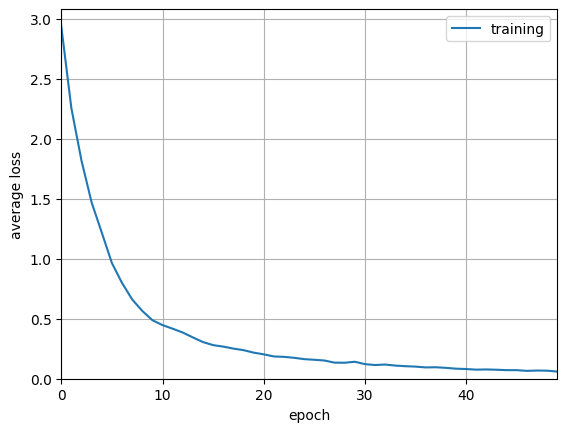

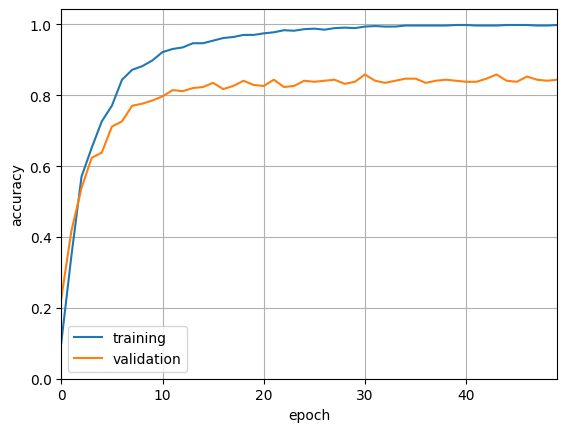

In [95]:
# plot loss curves
plt.plot(range(len(train_losses)), train_losses, label="training")
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.xlim(0, len(train_losses) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

# plot accuracy curves
plt.plot(range(len(train_accs)), train_accs, label="training")
plt.plot(range(len(val_accs)), val_accs, label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(0, len(train_accs) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

In [98]:
model = SqueezeNet().to(device)
model_state_dict_path = torch.load("./flower17_snet_model_checkpoint.pth")
model.load_state_dict(model_state_dict_path["model_state_dict"])

<All keys matched successfully>

In [99]:
test_accuracy = eval(model, test_loader)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.8205882352941176
